In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


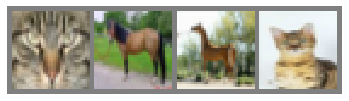

  cat horse horse   cat


In [14]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()
    
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(" ".join("%5s" % classes[labels[j]] for j in range(4)))

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()        

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print("Finished Training")

[1,  2000] loss: 2.186
[1,  4000] loss: 1.858
[1,  6000] loss: 1.653
[1,  8000] loss: 1.559
[1, 10000] loss: 1.513
[1, 12000] loss: 1.443
[2,  2000] loss: 1.374
[2,  4000] loss: 1.359
[2,  6000] loss: 1.351
[2,  8000] loss: 1.309
[2, 10000] loss: 1.278
[2, 12000] loss: 1.269
Finished Training


In [11]:
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

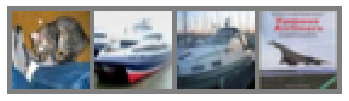

GroundTruth:    cat  ship  ship plane


In [22]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join("%5s" % classes[labels[j]] for j in range(4)))

In [16]:
outputs = net(images)
outputs

tensor([[-0.5451, -1.7960,  0.5097,  2.0415, -0.8244,  0.4333,  0.6961, -1.0456,
          0.0212, -1.3671],
        [ 6.4444,  4.6309,  0.2469, -2.8568, -2.8006, -5.5423, -4.9816, -4.3379,
          7.2409,  1.5677],
        [ 2.9393,  2.0849,  0.5286, -0.8872, -1.4641, -2.7166, -1.9935, -2.5186,
          3.8002,  0.1525],
        [ 3.2590,  0.2729,  0.8116, -0.7059, -1.3174, -2.6206, -1.5734, -1.8614,
          2.6480,  0.3214]], grad_fn=<AddmmBackward>)

In [17]:
_, predicted = torch.max(outputs, 1)
predicted

tensor([3, 8, 8, 0])

In [23]:
print("Predicted: ", " ".join("%5s" % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship plane


In [41]:
(predicted == labels)[0].item()

False

In [40]:
(predicted == labels).squeeze()

tensor([False, False, False, False])

In [34]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, label = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Accuracy of the network on the 10000 test images: {100*correct/total} %")

Accuracy of the network on the 10000 test images: 11.95 %


In [45]:
class_correct = list(0. for  i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    #print(f"Accuracy of {classes[i]}   : {100 * class_correct[i] / class_total[i]}")
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 64 %
Accuracy of   car : 68 %
Accuracy of  bird : 47 %
Accuracy of   cat : 52 %
Accuracy of  deer : 21 %
Accuracy of   dog : 29 %
Accuracy of  frog : 69 %
Accuracy of horse : 68 %
Accuracy of  ship : 70 %
Accuracy of truck : 62 %
